In [2]:
import findspark
findspark.init()

In [10]:
import pyspark
import os
import subprocess
import time
import datetime
import operator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from subprocess import Popen, PIPE
from pyspark.sql import SparkSession
from collections import defaultdict
from pyspark.sql.window import Window

import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
from pyspark.sql.functions import col, max as max_, min as min_, first, when
from pyspark.sql.functions import trunc, avg, countDistinct
from pyspark.sql.functions import dayofmonth,date_trunc,to_date,current_timestamp

In [4]:
spark = SparkSession.builder.appName("Activity3").getOrCreate()

## Load Dataset

In [27]:
# Generate full filenames
hdfs_prefix = 'hdfs://localhost:54310'
# hdfs_prefix = 'hdfs://localhost:9000'
prefix = f'{hdfs_prefix}/datasets/covid/'
filename_prefix = prefix+'part-'
filename_suffix = '-5f4af8d5-3171-48e9-9a56-c5a7c7a84cc3-c000.json'

filenames = []
for i in range(2):
    filenames.append(filename_prefix+f"{i:05d}"+filename_suffix)
filenames

['hdfs://localhost:54310/datasets/covid/part-00000-5f4af8d5-3171-48e9-9a56-c5a7c7a84cc3-c000.json',
 'hdfs://localhost:54310/datasets/covid/part-00001-5f4af8d5-3171-48e9-9a56-c5a7c7a84cc3-c000.json']

In [6]:
# Read all into a dataframe
df = spark.read.json(filenames)

In [7]:
# Convert datetime string to datetime type
df = df.withColumn("created_at", col("created_at").cast("timestamp"))

In [8]:
df.columns

['account_created_at',
 'account_lang',
 'country_code',
 'created_at',
 'favourites_count',
 'followers_count',
 'friends_count',
 'is_quote',
 'is_retweet',
 'lang',
 'place_full_name',
 'place_type',
 'reply_to_screen_name',
 'reply_to_status_id',
 'reply_to_user_id',
 'retweet_count',
 'screen_name',
 'source',
 'status_id',
 'text',
 'user_id',
 'verified']

## The situation about the country

In [41]:
df.select("country_code").where(df.country_code.isNotNull()).show()

+------------+
|country_code|
+------------+
|          GH|
|           0|
|        4432|
|          US|
|          US|
|           3|
|           0|
|          AR|
|           0|
|           2|
|          US|
|          GE|
|           3|
|        5975|
|        7554|
|           0|
|          US|
|          GW|
|          AU|
|          US|
+------------+
only showing top 20 rows



In [47]:
df.groupby("country_code").count().orderBy(col("count").desc()).limit(100).show()

+------------+------+
|country_code| count|
+------------+------+
|        null|470066|
|          US|  5217|
|           0|  3918|
|          IN|  3053|
|          GB|  1825|
|       FALSE|  1569|
|          ES|  1213|
|           1|   944|
|          TR|   857|
|          FR|   731|
|          MX|   670|
|          IT|   666|
|          BR|   658|
|          CO|   550|
|          NG|   525|
|          CA|   519|
|          AR|   516|
|          CL|   509|
|           2|   468|
|          ZA|   451|
+------------+------+
only showing top 20 rows



'country_code' == 'US' || 'place_full_name' == 'US'

In [48]:
df.groupby("place_full_name").count().orderBy(col("count").desc()).limit(100).show()

+--------------------+------+
|     place_full_name| count|
+--------------------+------+
|                null|476067|
|                   0|  1591|
|               FALSE|   602|
|                   1|   417|
|       Mumbai, India|   326|
|    New Delhi, India|   324|
|   İstanbul, Türkiye|   317|
|     Los Angeles, CA|   202|
|       Manhattan, NY|   202|
|                   2|   178|
|Bogotá, D.C., Col...|   168|
|       Madrid, Spain|   150|
|Ciudad Autónoma d...|   150|
|       Paris, France|   147|
|      Quito, Ecuador|   124|
|                   3|   123|
|         Rome, Lazio|   119|
|    Toronto, Ontario|   102|
|      Lagos, Nigeria|    99|
|      Washington, DC|    99|
+--------------------+------+
only showing top 20 rows



In [49]:
df.groupby("place_type").count().orderBy(col("count").desc()).limit(100).show()

+------------+------+
|  place_type| count|
+------------+------+
|        null|478713|
|        city| 18698|
|       admin|  2526|
|     country|  1034|
|         poi|   786|
|           0|   693|
|       FALSE|   206|
|           1|   157|
|neighborhood|    90|
|           2|    75|
|           3|    46|
|           4|    34|
|           5|    24|
|           8|    16|
|           6|    13|
|           7|    11|
|          US|    10|
|           9|    10|
|        TRUE|     9|
|          13|     8|
+------------+------+
only showing top 20 rows



## Grouping by date

In [29]:
# Find metric and count ocurrences
evolution = (
    df 
        .select(date_trunc('day', df.created_at).alias('day'),"text")
        .where(col("text").contains("#covid"))
        .groupby("day")
        .count()
)
evolution.show()

+-------------------+-----+
|                day|count|
+-------------------+-----+
|2020-04-11 00:00:00| 2795|
|2020-04-12 00:00:00|15847|
|2020-04-13 00:00:00|14247|
+-------------------+-----+



In [36]:
df2 = evolution.withColumn("day", to_date("day"))
df2.show()

+----------+-----+
|       day|count|
+----------+-----+
|2020-04-11| 2795|
|2020-04-12|15847|
|2020-04-13|14247|
+----------+-----+



In [20]:
# Find metric and count ocurrences
evolution = (
    df 
        .select("created_at","text")
        .where(col("text").contains("#corona"))
        .groupby(col("created_at").alias("day"))
        .count()
)
evolution.show()

+-------------------+-----+
|                day|count|
+-------------------+-----+
|2020-04-11 21:00:36|    2|
|2020-04-11 21:08:49|    1|
|2020-04-11 21:20:40|    1|
|2020-04-11 21:25:34|    1|
|2020-04-11 21:31:51|    3|
|2020-04-11 21:41:19|    2|
|2020-04-11 21:41:38|    1|
|2020-04-11 21:44:41|    1|
|2020-04-11 21:49:20|    1|
|2020-04-11 21:55:53|    1|
|2020-04-11 22:13:02|    1|
|2020-04-11 22:16:23|    1|
|2020-04-11 22:17:51|    1|
|2020-04-11 22:23:56|    1|
|2020-04-11 22:42:55|    1|
|2020-04-11 22:53:26|    1|
|2020-04-11 22:53:49|    3|
|2020-04-12 00:07:49|    2|
|2020-04-12 00:20:37|    1|
|2020-04-12 02:00:06|    2|
+-------------------+-----+
only showing top 20 rows



## Finding user using a tag per day

In [26]:
# Find how many (distinct) users (not tweets) used the tag each day
evolution = (
    df 
        .select(date_trunc('hour', df.created_at).alias('day'),"screen_name")
        .where(col("text").contains("#covid"))
        .where((df.country_code == "US") | (df.place_type == "US"))
        .groupBy("day")
        .agg(countDistinct("screen_name").alias("count"))
)
evolution.show()

+-------------------+-----+
|                day|count|
+-------------------+-----+
|2020-04-11 21:00:00|   22|
|2020-04-12 18:00:00|   11|
|2020-04-12 10:00:00|    8|
|2020-04-13 11:00:00|   17|
|2020-04-13 15:00:00|   13|
|2020-04-12 03:00:00|    5|
|2020-04-12 20:00:00|    8|
|2020-04-13 12:00:00|   11|
|2020-04-13 05:00:00|    1|
|2020-04-13 14:00:00|   14|
|2020-04-13 03:00:00|    3|
|2020-04-12 17:00:00|    7|
|2020-04-13 07:00:00|    2|
|2020-04-12 21:00:00|    8|
|2020-04-12 13:00:00|   11|
|2020-04-12 12:00:00|   14|
|2020-04-13 13:00:00|   16|
|2020-04-13 19:00:00|   12|
|2020-04-13 10:00:00|   11|
|2020-04-13 16:00:00|   15|
+-------------------+-----+
only showing top 20 rows



## Rolling Average

In [12]:
# Weekly rolling average window
w = (Window()
     .orderBy("day")
     .rowsBetween(-7, 0))

rolling = evolution.withColumn('rolling_average', avg('count').over(w))
rolling = rolling.select("day","rolling_average")
rolling.show()

+-------------------+------------------+
|                day|   rolling_average|
+-------------------+------------------+
|2020-04-11 21:00:00|              22.0|
|2020-04-11 22:00:00|              23.0|
|2020-04-11 23:00:00|21.666666666666668|
|2020-04-12 00:00:00|              21.0|
|2020-04-12 01:00:00|              19.4|
|2020-04-12 02:00:00|              18.0|
|2020-04-12 03:00:00|16.142857142857142|
|2020-04-12 04:00:00|            14.625|
|2020-04-12 05:00:00|              12.5|
|2020-04-12 06:00:00|             9.875|
|2020-04-12 07:00:00|             8.125|
|2020-04-12 08:00:00|             6.125|
|2020-04-12 09:00:00|             5.375|
|2020-04-12 10:00:00|               5.0|
|2020-04-12 11:00:00|              5.25|
|2020-04-12 12:00:00|               6.5|
|2020-04-12 13:00:00|              7.25|
|2020-04-12 14:00:00|             8.125|
|2020-04-12 15:00:00|              8.75|
|2020-04-12 16:00:00|            10.125|
+-------------------+------------------+
only showing top

In [15]:
rolling.coalesce(1).write.csv("task3")

In [16]:
# Convert last dataframe into dictionary for plotting
rows = [list(row) for row in rolling.collect()]
timeseries = {}
for [date, avg] in rows:
    timeseries[date] = avg

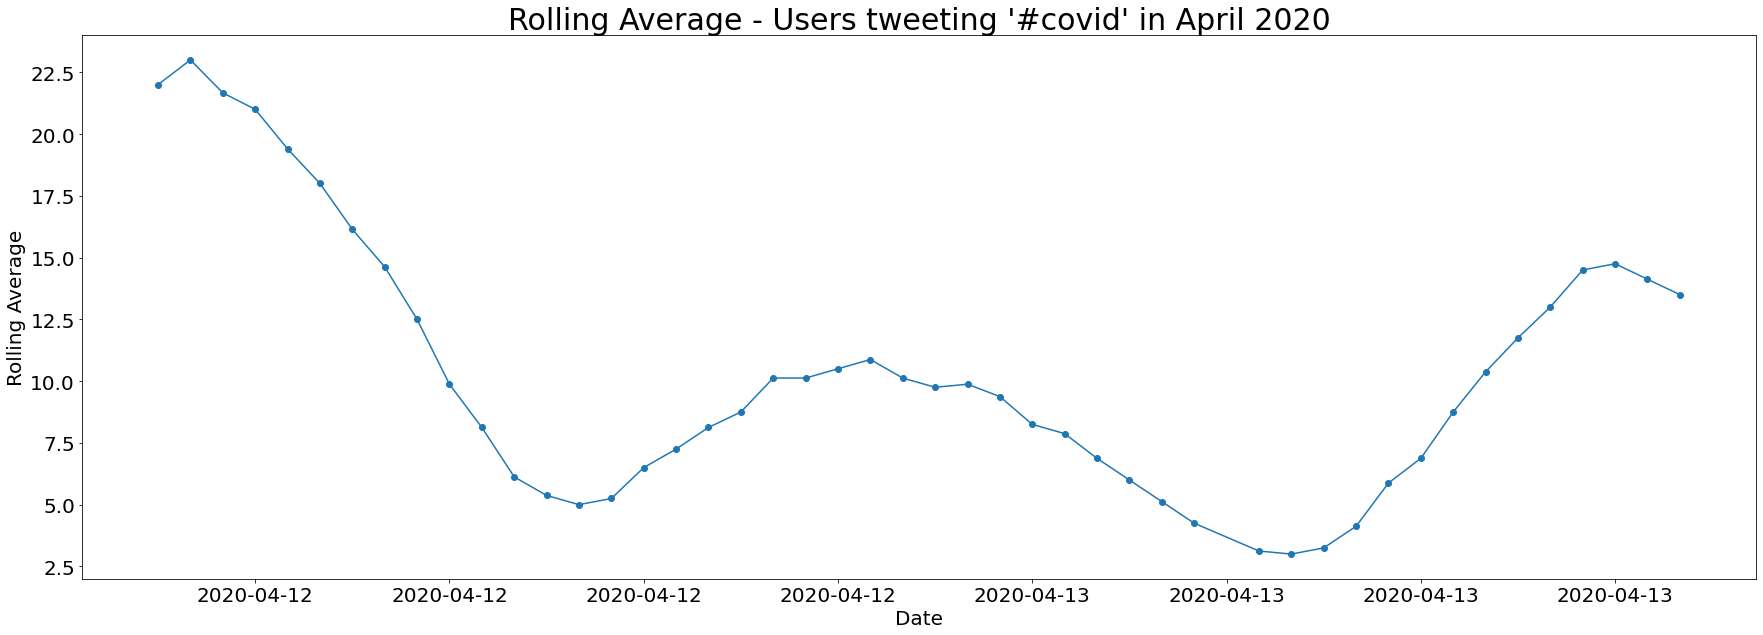

In [24]:
plt.figure(figsize=(30,10))
plt.title("Rolling Average - Users tweeting '#covid' in April 2020", fontsize=30)
plt.plot(timeseries.keys(),timeseries.values(),marker="o")
plt.ylabel("Rolling Average",fontsize=20)
plt.yticks(fontsize=20)
ax = plt.gca()
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date",fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.savefig('rolling_average.png', bbox_inches='tight')